**Import all the necessary libraries**

In [2]:
# !pip install blis
# !pip install spacy
# python -m spacy download en_core_web_sm
# !pip uninstall pandas
# !pip install pandas==1.5 matplotlib==3.6
# !python -m spacy download en_core_web_sm


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbs
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, log_loss, classification_report, accuracy_score,  roc_auc_score, roc_curve, auc
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import pickle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

**Importing The Data**

In [4]:
df_fake = pd.read_csv("Fake.csv")
df_true = pd.read_csv("True.csv")
df_fake['Label']='Fake'
df_true['Label']='True'
df_fake.shape, df_true.shape

((23481, 5), (21417, 5))

**Observation:**

*Here we observe that nearly all of the true texts contain the word "Reuters". This presence may lead to overfitting during model training. Hence, we will need to remove it during the data preprocessing stage.*

In [5]:
j=0
for i in df_true['text']:
    if '(Reuters)' in i:
        j+=1
j

21247

**Manual Testing Dataset**

In [6]:
df_manual=pd.DataFrame()
df_manual['title']=''
df_manual['text']=''
df_manual['subject']=''
df_manual['date']=''
df_manual['Label']=''


for i in range(516,526):
    df_manual.loc[len(df_manual)]= df_fake.loc[i]
    df_fake.drop(index=i, inplace=True, axis='index')
for i in range(487,498):
    df_manual.loc[len(df_manual)]= df_true.loc[i]
    df_true.drop(index=i, inplace=True, axis='index')
df_fake.shape, df_true.shape

((23471, 5), (21406, 5))

**Combining The Dataset**

In [7]:
df_train= pd.concat([df_fake, df_true], axis=0)
df_train

,title,text,subject,date,Label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",Fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",Fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",Fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",Fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",Fake
...,...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",True
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",True
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",True
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",True


In [8]:
df_train=df_train.sample(frac=0.5)

**Preprocessing Data**

In [9]:
df_train.shape

(22438, 5)

In [10]:
df_train.describe()

,title,text,subject,date,Label
count,22438,22438,22438,22438,22438
unique,20789,20644,8,2361,2
top,Factbox: Trump fills top jobs for his administ...,,politicsNews,"December 20, 2017",Fake
freq,8,313,5695,93,11675


In [11]:
df_train.head(5)

,title,text,subject,date,Label
2990,House overwhelmingly backs NATO mutual defense,WASHINGTON (Reuters) - The U.S. House of Repre...,politicsNews,"June 27, 2017",True
14202,Mexican leftist presidential candidate vows fi...,MEXICO CITY (Reuters) - Mexican leftist presid...,worldnews,"November 22, 2017",True
10004,DISGUSTING: CLEVELAND COPS JOIN Hate Group Who...,"Black Lives Matter, the group that many believ...",politics,"Sep 1, 2017",Fake
18676,NAIVE NEWS ANCHOR Reporting On “Refugees” Gets...,This is so disturbing but such a wake up call ...,left-news,"May 6, 2017",Fake
498,Top two Republicans in Congress challenge Demo...,WASHINGTON (Reuters) - The top two Republicans...,politicsNews,"November 28, 2017",True


In [12]:
df_train.fillna('', inplace=True)
df_train.isna().sum()

title      0
text       0
subject    0
date       0
Label      0
dtype: int64

In [13]:
df_train.drop_duplicates(inplace=True)
df_train.duplicated().sum()

0

In [14]:
df_train.reset_index(inplace=True)
df_train

,index,title,text,subject,date,Label
0,2990,House overwhelmingly backs NATO mutual defense,WASHINGTON (Reuters) - The U.S. House of Repre...,politicsNews,"June 27, 2017",True
1,14202,Mexican leftist presidential candidate vows fi...,MEXICO CITY (Reuters) - Mexican leftist presid...,worldnews,"November 22, 2017",True
2,10004,DISGUSTING: CLEVELAND COPS JOIN Hate Group Who...,"Black Lives Matter, the group that many believ...",politics,"Sep 1, 2017",Fake
3,18676,NAIVE NEWS ANCHOR Reporting On “Refugees” Gets...,This is so disturbing but such a wake up call ...,left-news,"May 6, 2017",Fake
4,498,Top two Republicans in Congress challenge Demo...,WASHINGTON (Reuters) - The top two Republicans...,politicsNews,"November 28, 2017",True
...,...,...,...,...,...,...
22374,5128,U.S. suspends fast processing of high-tech vis...,WASHINGTON (Reuters) - Foreigners aiming for t...,politicsNews,"March 4, 2017",True
22375,7051,Ann Coulter Just Made The Most Despicable Cla...,In response to Trump s outrageous remarks abou...,News,"April 7, 2016",Fake
22376,3827,REPORT: Civil Rights Groups Say Voter Suppres...,In the wake of election day and Donald Trump s...,News,"November 12, 2016",Fake
22377,22795,SUNDAY SCREENING: The Deep State: Hiding in Pl...,Our weekly documentary screening curated by th...,Middle-east,"September 3, 2017",Fake


**Code to Remove the word "Reuter"**

In [15]:
def reuters_removal(text):
    reuters_text=''
    reuters_text= text.split()
    reuters_text= [word for word in reuters_text if not word=="(Reuters)"]
    reuters_text= [word for word in reuters_text if not word=="Reuters"]
    reuters_text= " ".join(reuters_text)
    return reuters_text
df_train['text']=df_train['text'].apply(reuters_removal)

In [16]:
j=0
for i in df_train.loc[df_train['Label']=="True", 'text']:
    if '(Reuters)' in i:
        j+=1

j

4

**Data Visualization**

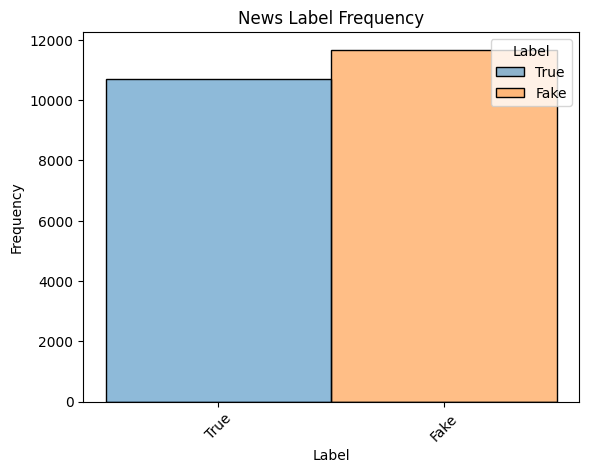

In [17]:
sbs.histplot(x='Label', hue='Label',data=df_train)
plt.title('News Label Frequency')
plt.xticks(rotation=45)
plt.ylabel('Frequency');

In [18]:
df_top=df_train.copy()
df_top_group=df_top.subject.value_counts()
df_top_group

politicsNews       5677
worldnews          5027
News               4487
politics           3389
left-news          2230
Government News     790
US_News             400
Middle-east         379
Name: subject, dtype: int64

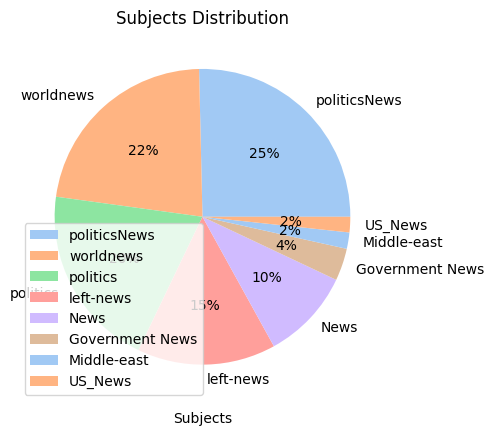

In [19]:
colors = sbs.color_palette('pastel')[0:6]
plt.pie(df_top_group,labels=df_top.subject.unique(),autopct='%.0f%%', colors=colors)
plt.title('Subjects Distribution')
plt.xlabel('Subjects')
plt.legend(df_top.subject.unique(), loc='lower left')
plt.show();

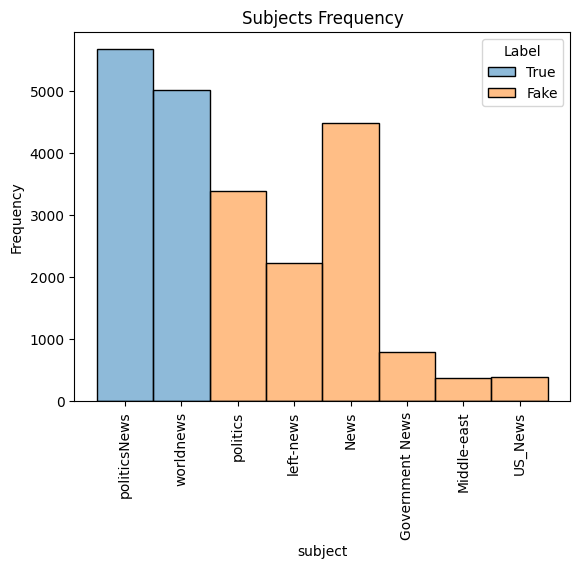

In [20]:
top_parties = df_train['subject'].value_counts().nlargest(5).index
df_top=df_train.copy()
df_top.loc[~df_top['subject'].isin(top_parties), 'Party'] = 'Other'
sbs.histplot(x='subject', hue='Label', data=df_top, stat='count')
plt.title('Subjects Frequency')
plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.show();

In [21]:
df_train.loc[df_train['subject']=="politicsNews","Label"].unique()

array(['True'], dtype=object)

**Splitting The Data**

*We will split the dataset into training and testing sets. Additionally, we will encode the labels into numerical values to facilitate the calculation of the reliability percentage of the news articles.*

In [22]:
y= df_train['Label']
X=df_train.drop(['Label', "date",'index'], axis=1)
y.unique()

array(['True', 'Fake'], dtype=object)

In [23]:
X

,title,text,subject
0,House overwhelmingly backs NATO mutual defense,WASHINGTON - The U.S. House of Representatives...,politicsNews
1,Mexican leftist presidential candidate vows fi...,MEXICO CITY - Mexican leftist presidential fro...,worldnews
2,DISGUSTING: CLEVELAND COPS JOIN Hate Group Who...,"Black Lives Matter, the group that many believ...",politics
3,NAIVE NEWS ANCHOR Reporting On “Refugees” Gets...,This is so disturbing but such a wake up call ...,left-news
4,Top two Republicans in Congress challenge Demo...,WASHINGTON - The top two Republicans in the U....,politicsNews
...,...,...,...
22374,U.S. suspends fast processing of high-tech vis...,WASHINGTON - Foreigners aiming for temporary j...,politicsNews
22375,Ann Coulter Just Made The Most Despicable Cla...,In response to Trump s outrageous remarks abou...,News
22376,REPORT: Civil Rights Groups Say Voter Suppres...,In the wake of election day and Donald Trump s...,News
22377,SUNDAY SCREENING: The Deep State: Hiding in Pl...,Our weekly documentary screening curated by th...,Middle-east


**Stemming and Stop Words**

In [24]:
port_stemmer= PorterStemmer()
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def stemmer(text):
    # Process the text
    doc = nlp(text)

    # Extract the lemma of each token if it is not a stopword or punctuation
    return ' '.join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])
X['text']= X['text'].apply(stemmer)
X=X['text']
X

0        WASHINGTON U.S. House Representatives vote nea...
1        MEXICO CITY mexican leftist presidential front...
2        black life Matter group believe hate group dom...
3        disturbing wake people don t realize s go Euro...
4        WASHINGTON Republicans U.S. Congress say lead ...
                               ...                        
22374    WASHINGTON foreigner aim temporary job high te...
22375    response Trump s outrageous remark abortion An...
22376    wake election day Donald Trump s win Americans...
22377    weekly documentary screening curate editorial ...
22378    today end Y Donald Trump take twitter account ...
Name: text, Length: 22379, dtype: object

**Train Test Split**

In [26]:
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=40, stratify=y)

**TF-IDF Vectorization**

*TF-IDF (Term Frequency-Inverse Document Frequency) is a technique used to represent text data numerically*

In [27]:
vectorization = TfidfVectorizer()
xv_train = vectorization.fit_transform(X_train)
xv_test = vectorization.transform(X_test)

**Model Training Using Logistic Regression**

In [28]:
lgr=LogisticRegression(max_iter=1000)
lgr.fit(xv_train,y_train)

LogisticRegression(max_iter=1000)

In [29]:
y_pred=lgr.predict(xv_test)
acc = accuracy_score(y_pred,y_test)
print("Accuracy: ", round(acc*100,1 ), "%")
print(classification_report(y_test, y_pred))

Accuracy:  97.5 %
              precision    recall  f1-score   support

        Fake       0.98      0.97      0.98      2335
        True       0.97      0.98      0.97      2141

    accuracy                           0.97      4476
   macro avg       0.97      0.97      0.97      4476
weighted avg       0.97      0.97      0.97      4476



**Testing**

In [30]:
def manual_testing(news):
    testing_news = {"text":[news]}
    new_def_test = pd.DataFrame(testing_news)
    new_def_test["text"] = new_def_test["text"].apply(reuters_removal)

    new_def_test["text"] = new_def_test["text"].apply(stemmer)
    new_x_test = new_def_test["text"]
    new_xv_test = vectorization.transform(new_x_test)
    prediction= lgr.predict(new_xv_test)
    return prediction[0]
manual_testing(df_manual.loc[12,'text'])

'True'

In [31]:
df_manual

,title,text,subject,date,Label
0,"Did Ron Paul Just Confuse Al-Qaeda With ISIS,...",Former Texas Congressman Ron Paul added yet mo...,News,"August 22, 2017",Fake
1,Congressional Black Caucus Signals That They ...,"The Congressional Black Caucus, like most Demo...",News,"August 21, 2017",Fake
2,Body-Slamming Republican Thought He Was Too I...,"You may remember Greg Gianforte, the Republica...",News,"August 21, 2017",Fake
3,Ron Paul Blames Obama For A Stock Market Cras...,"Ron Paul, who s a retired doctor, not an econo...",News,"August 21, 2017",Fake
4,GOP Lawmaker Blames Obama For Staging Racist ...,"According to Republican lawmaker from Idaho, i...",News,"August 21, 2017",Fake
5,Twitter Has Absolute Field Day Laughing At Tr...,Scientists have been warning the world for wee...,News,"August 21, 2017",Fake
6,Donald Trump Never Met A Disaster He Couldn’t...,Back when conservative politics were actually ...,News,"August 21, 2017",Fake
7,Thousands Of Advertisers Are Fleeing From Fak...,Donald Trump s former Chief Strategist Stephen...,News,"August 21, 2017",Fake
8,Trump’s Response To USS John S. McCain Collis...,It s common knowledge that Donald Trump is a s...,News,"August 21, 2017",Fake
9,Secret Service Officially Can’t Afford To Pay...,Donald Trump has been wasting taxpayer dollars...,News,"August 21, 2017",Fake
